# Create baseline model
We are going to create a baseline model so we have a benchmark to compare our other models to

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from src.plots import plot_feature_importances

In [2]:
X_train_df = pd.read_csv("output/train_data_normalized.csv")
X_test_df = pd.read_csv("output/test_data_normalized.csv")
y_train_df = pd.read_csv("output/train_labels.csv")
y_test_df = pd.read_csv("output/test_labels.csv")
features = X_train_df.columns

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()
y_test = y_test_df.to_numpy().ravel()

label_names = ["non-smoker", "smoker"] # 0 = non-smoker and 1 = smoker

In [3]:
treeclf_default = tree.DecisionTreeClassifier(random_state=17)
treeclf_default = treeclf_default.fit(X_train, y_train)
treepreds_default_test = treeclf_default.predict(X_test)

train_default_score = treeclf_default.score(X_train, y_train)
test_default_score = treeclf_default.score(X_test, y_test)
print(f"Train Score: {train_default_score}, Test Score: {test_default_score}")

Train Score: 1.0, Test Score: 0.7475952289342055


The model above is overfitting so we are going to try and tune the Tree to see if we can get a more generalized model. We are going to use GridSearch to help tune the parameters

In [4]:
gscv_clf = tree.DecisionTreeClassifier()

params = {
    "max_depth": [5],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [5, 10],
    "random_state": [17]
}

grid_search = GridSearchCV(gscv_clf, params, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'random_state': 17}


Apply best paramerets to new classifier

In [5]:
treeclf_params = tree.DecisionTreeClassifier(**grid_search.best_params_)
treeclf_params = treeclf_params.fit(X_train, y_train)
treepreds_params_test = treeclf_params.predict(X_test)

train_params_score = treeclf_params.score(X_train, y_train)
test_params_score = treeclf_params.score(X_test, y_test)
print(f"Train Score: {train_params_score}, Test Score: {test_params_score}")

Train Score: 0.7290858370474878, Test Score: 0.7305373861741695


Our accuracy went down ~ 1%, but we the model is more generalized - and we the tree should interpretable still based on the params we passed.

In [6]:
tree.export_graphviz(treeclf_params, out_file='output/tree.dot', feature_names=X_train_df.columns, class_names=label_names, filled=True)

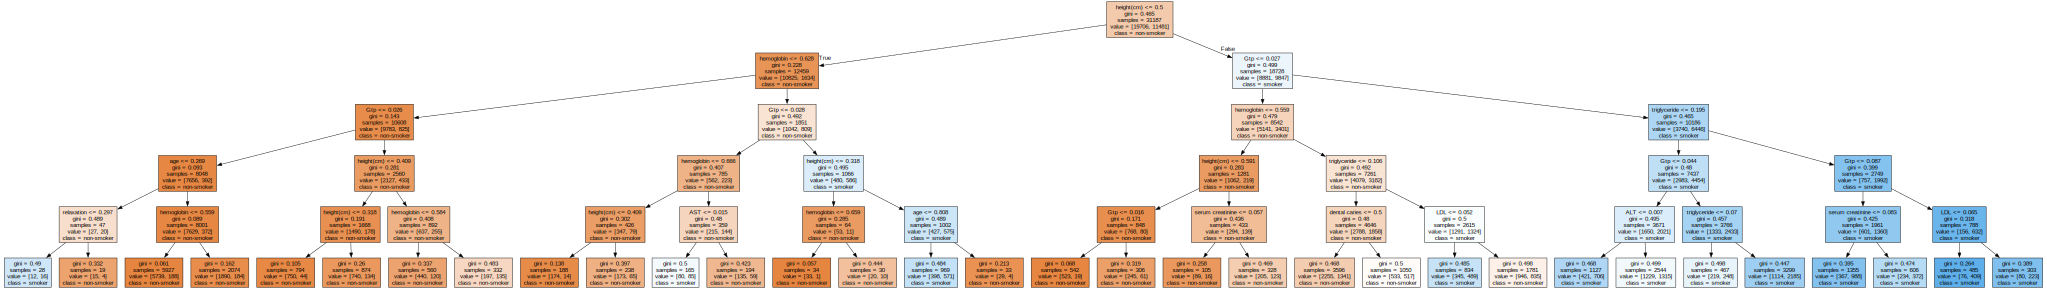

In [7]:
with open("output/tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [8]:
print(classification_report(y_test, treepreds_params_test, target_names=label_names))

              precision    recall  f1-score   support

  non-smoker       0.80      0.77      0.78      4960
      smoker       0.62      0.66      0.64      2837

    accuracy                           0.73      7797
   macro avg       0.71      0.72      0.71      7797
weighted avg       0.73      0.73      0.73      7797



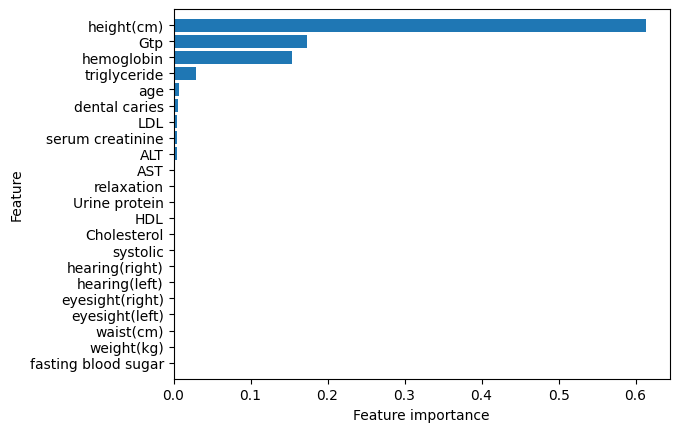

In [9]:
plot_feature_importances(treeclf_params, len(X_train_df.columns), X_train_df.columns)

Based on our Tree - height, Gtp, hemoglobin are the most import features. There's a small amount of relevance getting associated to triglceride, age, dental aries, LDL, serum creatine, and ALT as well.